# 更多 PyTorch 技巧 -- 灵活配置网络结构

本文主要根据补充一些相对高级的PyTorch编程技巧，以帮助实现更灵活的网络结构。

主要参考资料有：

- [Paperspace/PyTorch-101-Tutorial-Series](https://github.com/Paperspace/PyTorch-101-Tutorial-Series)
- [pytorch系列8 --self.modules() 和 self.children()的区别](https://blog.csdn.net/dss_dssssd/article/details/83958518)
- [pytorch系列10 --- 如何自定义参数初始化方式 ，apply()](https://blog.csdn.net/dss_dssssd/article/details/83990511)
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)

首先，进一步明确PyTorch中的基本概念。然后在自定义权重初始化，打印网络信息，设置学习率等方面给出一些示例。

## nn.Module、nn.Functional、nn.Parameter、nn.ModuleList 和 nn.ParameterList

在 PyTorch 中，层通常被实现为torch.nn.Module对象或torch.nn.Functional函数。

torch.nn.Module是 PyTorch 的基石。它的工作方式是首先定义一个nn.Module对象，然后调用它的forward方法来运行它。这是一种面向对象的做事方式。

而nn.functional以函数的形式提供一些层/激活函数，可以直接在输入上调用而不是定义一个对象。

那么我们如何选择何时使用什么？

通常，任何层都可以看作是一个函数。例如，卷积运算只是一堆乘法和加法运算。但是不能仅仅把它作为一个函数来实现，因为该层拥有我们在训练时需要存储和更新的权重。因此，从编程的角度来看，**层不仅仅是函数，它还需要保存数据，随着我们训练网络而变化**。

也就是说事实是卷积层保存的数据会发生变化。这意味着该层的状态会随着我们的训练而变化。所以，为了实现一个执行卷积运算的函数，我们还需要定义一个数据结构，以将层的权重与函数本身分开保存。然后，将此外部数据结构作为我们函数的输入。

或者为了避免麻烦，我们可以定义一个类来保存数据结构，并将卷积操作作为成员函数进行。这会减轻我们的工作，因为我们不必担心函数外部存在的有状态变量。在这些情况下，我们更愿意使用具有权重或其他可能定义层行为的状态的nn.Module对象。

而在不需要状态或权重的情况下，可以使用nn.functional. 例如，调整大小 ( nn.functional.interpolate)、平均池化 ( nn.functional.AvgPool2d)。

大多数nn.Module类nn.functional上都有对应的函数，不过，在实际工作中要尽量遵守上述推理的路线指示。

PyTorch 中的另一项重要内容是nn.Parameter，不过这部分内容在 PyTorch 的介绍文档中几乎没怎么涉及。

In [15]:
import torch
from torch import nn

In [13]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,1,2)
    
    def forward(self, x):
        return self.linear(x)

myNet = net()

#prints the weights and bias of Linear Layer
print(list(myNet.parameters()))     

[Parameter containing:
tensor([[[[-0.1194, -0.0077],
          [ 0.1883, -0.2215]],

         [[-0.0118, -0.2719],
          [ 0.1139, -0.1124]],

         [[ 0.0921, -0.1163],
          [-0.2726,  0.0559]]]], requires_grad=True), Parameter containing:
tensor([-0.1083], requires_grad=True)]


每个nn.Module都有一个parameters()函数，该函数返回模型可训练的参数。我们必须隐式定义这些参数是什么。在 nn.Conv2d 的定义中，PyTorch 的作者将权重和偏差定义为层的参数。但是，请注意，当我们定义上面例子中的net时，我们不需要将nn.Conv2d的parameters添加到net的parameters。它是通过**将nn.Conv2d对象设置为net对象的成员而隐式地发生**。

这是由nn.Parameter类内部促成的。nn.Parameter类是Tensor类的子类。当我们调用一个nn.Module对象的parameters()函数时，它会返回它的所有nn.Parameter对象成员。

事实上，nn.Module类的**所有训练权重都是作为nn.Parameter对象实现的**。每当 一个nn.Module（在上面例子中是nn.Conv2d）被分配为另一个nn.Module的成员时，其“参数”（即 nn.Conv2d的权重）也会被添加到被分配的对象的“参数”（net对象的参数）。这称为注册一个nn.Module的“参数”。

如果尝试**为nn.Module对象设置Tensor，那么除非将其定义为nn.Parameter对象，否则它不会显示在parameters()中**。这样做是为了方便可能需要缓存不可微张量的场景，例如，在 RNN 的情况下缓存先前的输出（可以参考[这里](https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter)查看更多例子）。

In [16]:
class net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,1,2)
        self.tens = torch.ones(3,4)  # This won't show up in a parameter list 
    
    def forward(self, x):
        return self.linear(x)

myNet = net1()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[[[-0.2860,  0.0241],
          [-0.1872,  0.1536]],

         [[ 0.0584,  0.1894],
          [-0.0220, -0.1746]],

         [[-0.2775,  0.1459],
          [ 0.2474, -0.2382]]]], requires_grad=True), Parameter containing:
tensor([0.2595], requires_grad=True)]


In [17]:
class net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,1,2)
        self.tens = nn.Parameter(torch.ones(3,4))  # This will show up in a parameter list 
    
    def forward(self, x):
        return self.linear(x)

myNet = net2()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[[[ 0.1319, -0.0816],
          [ 0.2381,  0.1275]],

         [[ 0.0039, -0.2364],
          [ 0.2400,  0.0394]],

         [[-0.2768,  0.1944],
          [-0.0019, -0.0693]]]], requires_grad=True), Parameter containing:
tensor([-0.0314], requires_grad=True)]


In [18]:
class net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,1,2)
        self.net  = net2()  # Parameters of net2 will show up in list of parameters of net3
    
    def forward(self, x):
        return self.linear(x)

myNet = net3()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[[[ 0.2879, -0.0817],
          [ 0.2419,  0.0733]],

         [[-0.0097, -0.0409],
          [-0.1582, -0.2624]],

         [[-0.2869,  0.1579],
          [-0.0872,  0.1976]]]], requires_grad=True), Parameter containing:
tensor([-0.1602], requires_grad=True), Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[[[-0.1552, -0.0187],
          [-0.2253, -0.0373]],

         [[ 0.2697, -0.0904],
          [-0.1829, -0.1124]],

         [[-0.0589, -0.2755],
          [-0.2701,  0.0020]]]], requires_grad=True), Parameter containing:
tensor([-0.0828], requires_grad=True)]


PyTorch的__init__函数和forward函数起到的作用就像是搭积木和在积木上前行。当我们的积木有多个模块的时候，我们会期望用一种简单的方式来描述：

In [19]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = layer_list
    
    def forward(x):
        for layer in self.layers:
            x = layer(x)

net = myNet()

print(list(net.parameters()))  # Parameters of modules in the layer_list don't show up.

[]


但是如上所见，与我们注册单个模块时不同，将模块放入 Python 列表中并不会就对应地在参数列表中注册模块的参数。为了解决这个问题，我们用nn.ModuleList类包装我们的列表，然后将它分配为网络类的成员即可。

In [22]:
layer_list = [nn.Conv2d(3,2,1), nn.BatchNorm2d(2), nn.Linear(2,1)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(layer_list)
        
    def forward(x):
        for layer in self.layers:
            x = layer(x)

net = myNet()

print(list(net.parameters()))  # Parameters of modules in layer_list show up.

[Parameter containing:
tensor([[[[ 0.5095]],

         [[ 0.4851]],

         [[ 0.4200]]],


        [[[ 0.4534]],

         [[-0.3264]],

         [[-0.2496]]]], requires_grad=True), Parameter containing:
tensor([ 0.5592, -0.4525], requires_grad=True), Parameter containing:
tensor([1., 1.], requires_grad=True), Parameter containing:
tensor([0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.4126,  0.6459]], requires_grad=True), Parameter containing:
tensor([0.4655], requires_grad=True)]


类似地，可以通过将列表包装在 nn.ParameterList 类中来注册Tensor的list。

In [23]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(3, 4)) for i in range(2)])

    def forward(self, x):
        # ParameterList can act as an iterable, or be indexed using ints
        for i, p in enumerate(self.params):
            x = self.params[i // 2].mm(x) + p.mm(x)
        return x
    
net = MyModule()

print(list(net.parameters()))

[Parameter containing:
tensor([[ 0.3802, -0.0107,  2.1134, -1.0010],
        [-1.2872,  0.2011, -1.0356,  0.1645],
        [ 1.3798, -0.1055, -0.9116, -0.5409]], requires_grad=True), Parameter containing:
tensor([[-0.2182, -0.3539,  1.8967,  0.6996],
        [ 2.1958,  0.6154, -0.2691, -0.9589],
        [-0.2542, -0.9728, -1.0709, -0.3059]], requires_grad=True)]


C:\Users\11445\miniconda3\envs\hydrus\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


## 自定义权重初始化

权重初始化会影响训练结果。更重要的是，对于不同类型的层，可能需要不同的权重初始化方案。这时候，我们可以通过 modules 和 apply 函数来完成。modules 是 nn.Module 类的一个成员函数，它返回一个包含 nn.Module函数的所有nn.Module成员的成员对象的迭代器。然后使用 apply 函数可以在每个 nn.Module 上调用 初始化函数 来设置它的初始化。下面的例子，直接将 weights_init函数写在module内，所以没用到apply函数。它和一个单独写的函数，然后用apply作用到module上是一样的，不过因为apply函数是递归地的运用在由self.children()返回的每个子模块上（如下图所示，更多内容可参考[PyTorch文档nn.Module介绍](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)），所以会有点区别。这里也给出一个例子。

![](img/QQ截图20210707213344.jpg)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


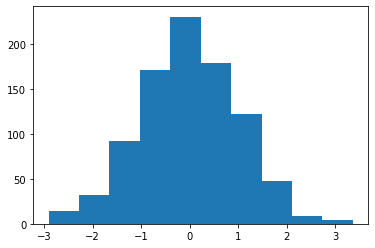

In [24]:
import matplotlib.pyplot as plt

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(10,10,3)
        self.bn = nn.BatchNorm2d(10)
        
    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean = 0, std = 1)
                nn.init.constant_(module.bias, 0)

net = myNet()
net.weights_init()

for module in Net.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias)  # Bias to zero
        plt.hist(weights)
        plt.show()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


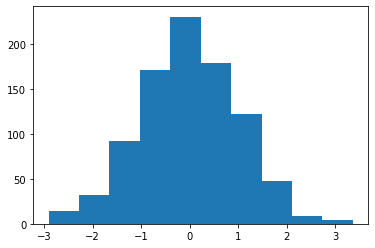

In [26]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(10,10,3)
        self.bn = nn.BatchNorm2d(10)
        
def weights_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight, mean = 0, std = 1)
        nn.init.constant_(module.bias, 0)

net = myNet()
net.apply(weights_init)

for module in Net.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias)  # Bias to zero
        plt.hist(weights)
        plt.show()

在torch.nn.init模块中可以找到大量的inplace初始化函数。

children是和modules非常相似的函数，虽然差异很小但很重要。正如我们所知，一个nn.Module对象可以包含其他nn.Module对象作为它的数据成员。

而children()只返回一个nn.Module对象列表，这些对象是调用children的对象的数据成员。

nn.Modules在每个nn.Module对象内部递归，创建nn.Module沿途出现的每个对象的列表，直到没有nn.module对象为止。注意，modules()还返回作为列表的一部分被调用的nn.Module。也就是说self.modules()采用深度优先遍历的方式，存储了 net 的所有模块，而children()只包括net的第一代儿子模块。

请注意，上述描述对于从nn.Module类继承的所有对象/类仍然适用。

In [25]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN =  nn.Sequential(nn.Conv2d(10,10,3), nn.BatchNorm2d(10))
        self.linear =  nn.Linear(10,2)
    def forward(self, x):
        pass

net = myNet()

print("Printing children\n------------------------------")
print(list(net.children()))
print("\n\nPrinting Modules\n------------------------------")
print(list(net.modules()))

Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


因此，当我们初始化权重时，我们可能想要使用modules()函数，因为我们无法进入nn.Sequential对象内部并为其成员初始化权重。

另外，初始化函数也可以重写 reset_parameters()方法实现，具体可以参考 nn.Linear 等的源码。

## 打印有关网络的信息

我们可能需要打印有关网络的信息，无论是为了用户还是出于调试目的。PyTorch 提供了一种非常简洁的方式来使用它的named_* 功能打印大量有关网络的信息。有4个这样的函数。

1. named_parameters. 返回一个迭代器，它给出一个包含参数名称的元组（如果一个卷积层被分配为self.conv1，那么它的参数将是conv1.weight和conv1.bias）以及由nn.Parameter的__repr__函数返回的值
2. named_modules. 同上，但迭代器像modules()函数一样返回模块。
3. named_children同上，但迭代器如     children()返回那样返回模块
4. named_buffers返回缓冲区张量，例如 Batch Norm 层的运行均值。

In [27]:
for x in net.named_modules():
    print(x[0], x[1], "\n-------------------------------")

 myNet(
  (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
conv Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
bn BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------


In [29]:
# for p in net.named_parameters():
#     print(p[0], p[1], "\n-------------------------------")

## 不同层的不同学习率

如何为不同的参数组使用不同的超参数，无论是不同层的不同学习率，还是偏差和权重的不同学习率？

实现的想法相当简单。通常我们将网络的所有参数作为一个整体传递给优化器对象，如下所示。

In [30]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)
    def forward(self, x):
        return self.fc2(self.fc1(x))
net = myNet()
optimiser = torch.optim.SGD(net.parameters(), lr = 0.5)

但是，torch.optim类允许我们以字典的形式提供具有不同学习率的不同参数集。

In [31]:
optimiser = torch.optim.SGD([{"params": net.fc1.parameters(), 'lr' : 0.001, "momentum" : 0.99},
                             {"params": net.fc2.parameters()}], lr = 0.01, momentum = 0.9)

在上述设置中，fc1 参数使用 0.01 的学习率和 0.99 的 momentum 。如果没有为一组参数指定超参数（例如 这里的fc2)，那么会使用该超参数的默认值，作为优化器函数的输入参数。可以使用上面介绍的named_parameters()函数基于不同的层创建参数列表，或者不管参数是权重还是偏差。

另一个常用的学习率设置是学习率在训练不同阶段的调度。

学习率调度也是常常想要调整的主要超参数之一。PyTorch 的torch.optim.lr_scheduler模块提供了对学习率调度的支持，该模块具有多种学习率调度。下面的示例演示了一个这样的示例。

In [32]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones = [10,20], gamma = 0.1)

当每次我们到达milestones列表中包含的epoch时，上面的调度程序会将学习率乘以gamma。在上面的例子中，学习率在第 10 个和第 20 个epoch会分别乘以 0.1。另外，还必须在遍历 epoch 的代码的循环中编写一行scheduler.step，以便更新学习率。

通常，训练循环由两个嵌套循环组成，其中一个循环遍历 epoch，其中嵌套的循环遍历该 epoch 中的batch。需要确保scheduler.step在 epoch 循环开始时调用，以便更新您的学习率。注意不要写在batch的循环中，否则学习率可能会在第 10 个批次而不是第 10 个 epoch 时更新。

还要记住，这scheduler.step不是optim.step的替代品，每次向后反向传播时都必须调用optim.step（这是在“batch”循环中）。